In [6]:
import sys

import pandas as pd
import numpy as np
from scipy import signal

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from datetime import datetime

import sqlite3 as lite


In [2]:
def save_event(name, connection_path='/Users/b/Library/Containers/com.hesterlab.smartppe.facebit-app/Data/Documents/db.sqlite'): 
    conn = lite.connect(database_path)
    # conn = lite.connect('/Users/b/Downloads/db_mask_on.sqlite')
    events_query = f"""
        SELECT t.id, t.value, t.date, read.data_type as type, e.id as event_id, e.event_type, read.frequency 
        FROM time_series_measurement as t
        LEFT JOIN event as e ON e.id = t.event_id
        LEFT JOIN time_series_data_read as read ON t.data_read_id = read.id
        WHERE e.id == {18}
        ORDER BY t.date ASC
    """

    df = pd.read_sql_query(events_query, conn)
    df = df.where(df['type'] == 'pressure').dropna()
    df.to_csv(f'mask-wear-events/{name}.csv')

    return df

In [3]:
events = [pd.read_csv(f'mask-wear-events/{f}') for f in os.listdir('mask-wear-events')]

In [7]:
def plot_on_off(df):

    mean_freq = df['frequency'].mean()
    std_freq = df['frequency'].std()
    print(f'Mean of Frequency: {mean_freq:.4f}\nStandard Deviation frequency: {std_freq:.4f}')
    
    diffs = []
    stdevs = []
    signal = df['value'].to_numpy()

    window = int(mean_freq * 5)
    stride = int(mean_freq * 5)

    print(len(signal), window)

    for i in range(0, len(signal)-window, stride):
        sample = signal[i:i+window]
        diffs.append(max(sample) - min(sample))
        stdevs.append(np.std(sample))

    diffs = np.array(diffs)
    stdevs = np.array(stdevs)

    plt.plot(diffs)
    plt.plot(np.repeat([0.15], len(diffs))) 
    plt.show()
    
    plt.plot(stdevs)
    plt.plot(np.repeat([0.04], len(stdevs)))
    plt.show()

    is_on = diffs > 0.15

    state_changes = []
    for i, state in enumerate(is_on[:-1]):
        if is_on[i+1] != state:
            next_state_change_idx = np.argmax(is_on[i+1:]==state)
            print(next_state_change_idx)
            
            if next_state_change_idx >= 3 or next_state_change_idx==0: 
                state_changes.append(1)
                continue
        

        state_changes.append(0)

    is_on = np.repeat(is_on, len(signal)/len(is_on))
    state_changes = np.repeat(state_changes, len(signal)/len(state_changes))

    with PdfPages('mask_on_off_detection.pdf') as export_pdf:

        fig, ax1 = plt.subplots(figsize=(12,6))
        ax1.plot(signal, label='Pressure Signal')

        ax2 = ax1.twinx()
        ax2.plot(is_on, c='gray', label='Threshold Detection')
        ax2.plot(state_changes, c='red', label="State Change")

        ax1.set_title("Mask On/Off Detection", fontweight='bold')
        ax1.set_xlabel(f'Time ({mean_freq:.2f}Hz)', fontweight='bold')
        ax1.set_ylabel('mBar', fontweight='bold')

        ax1.text(750, 1007.75, 'breathing', fontweight='bold')
        ax1.text(1550, 1008.25, 'down stairs', fontweight='bold')
        ax1.text(2500, 1008.5, 'outside', fontweight='bold')
        ax1.text(3925, 1008.0, 'up stairs', fontweight='bold')
        ax1.text(4900, 1008.0, 'heavy breathing', fontweight='bold')

        ax2.set_ylabel('Trigger', fontweight='bold')
        ax2.set_yticks([0.0, 1.0])
        ax2.set_yticklabels(['Off', 'On'])
        fig.legend(loc=(0.25,0.2))
        
        export_pdf.savefig()
        plt.show()



Mean of Frequency: 25.4460
Standard Deviation frequency: 0.0187
5759 127


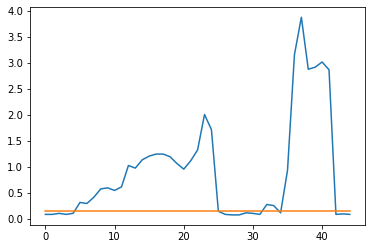

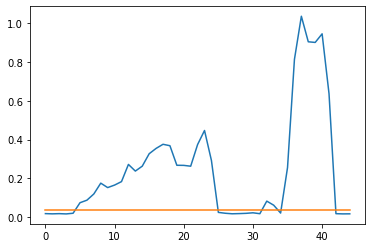

21
6
2
1
7
0


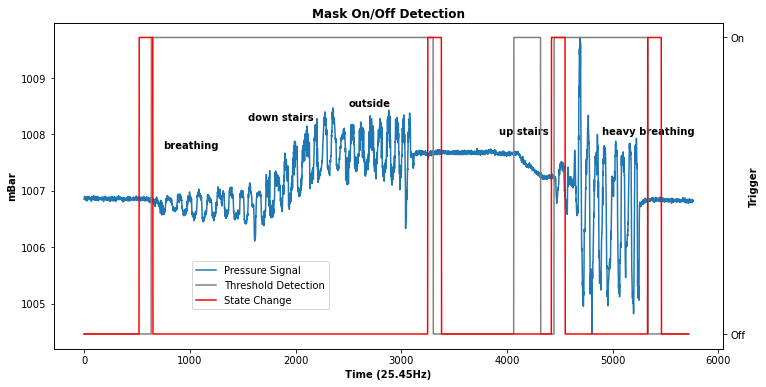

In [8]:
plot_on_off(events[0])